In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sys
import numpy as np
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table, weekday_time_series
import torch
import gpytorch

### Seasonality

Data is collected at 5 minute intervals over a 10 day timespan

Frequency = Number of observations per _season_ or _cycle_

Season = Hour, Day, Week, Month, Quarter, Year

_Note_: In Fourier analysis, “period” is the length of the cycle, and “frequency” is the inverse of period

Daily seasonality frequency of $288 = (24 * 60) / 5$

Day of week seasonality frequency of $2016 = (288 * 7)$

Work Week seasonality frequency of $1440 = (288 * 5)$

In [10]:
trock_10T = query_table(table='r707lv_trockner_10T')

In [12]:
trock_10T.index.max() - trock_10T.index.min()

Timedelta('10 days 00:00:00')

In [ ]:
#trock_10T['t'] = (trock_10T.index- trock_10T.index.min()) / (trock_10T.index.max() - trock_10T.index.min())

In [11]:
px.line(data_frame=trock_10T, x=trock_10T.index, y='p')

/var/folders/5n/lzw120x534d6n5nbhk8qwzjr0000gs/T/ipykernel_42941/3621650978.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



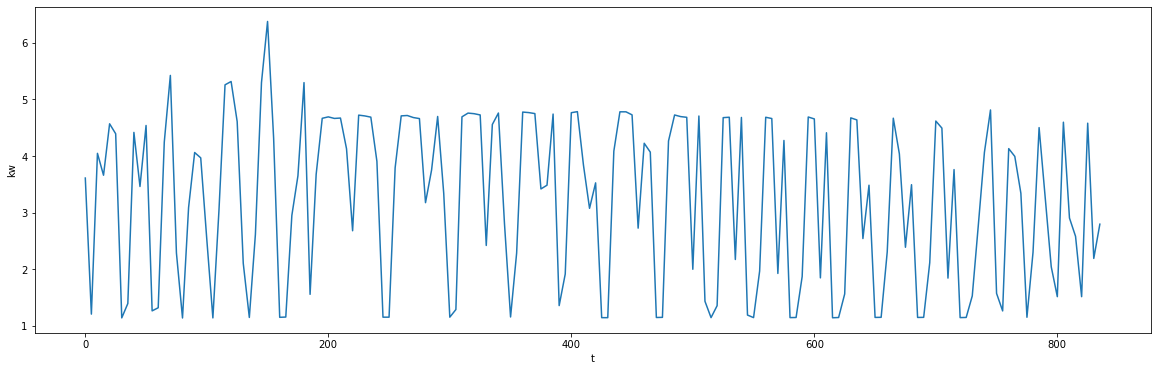

In [245]:
all = trock_10T[(trock_10T.index.day == 8) & (trock_10T.index.hour > 9)] ## for pedagoical reasons

time_int_range = np.arange(0, 168*5, 5)
all['t'] = time_int_range

X = all['t'].values
y = all['kw'].values

n = len(X)

prop_train = 0.7
n_train = round(prop_train * n)

X_train = torch.from_numpy(X[:n_train]).to(torch.float32)
y_train = torch.from_numpy(y[:n_train]).to(torch.float32)


y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)
#y_train = (y_train - y_train_mean) / y_train_std

X_test = torch.from_numpy(X[n_train:]).to(torch.float32)
y_test = torch.from_numpy(y[n_train:]).to(torch.float32)

#y_test = (y_test - y_train_mean) / y_train_std


plt.figure(figsize=(20, 6))
sns.lineplot(x=all.t, y=all.kw)
plt.show()

In [284]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        #lengthscale_prior = gpytorch.priors.GammaPrior(0.5, 1.5)
        #period_prior = gpytorch.priors.NormalPrior(10, 2)
        #period_constraint = [35, 45]
        #period_constraint = gpytorch.constraints.Interval(5, 15)

        lengthscale_prior = gpytorch.priors.GammaPrior(3.0, 6.0)
        outputscale_prior = gpytorch.priors.GammaPrior(2.0, 0.15)

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.RBFKernel()
            )
        
        #self.covar_module = gpytorch.kernels.ScaleKernel(
        #    gpytorch.kernels.PeriodicKernel(
        #        lengthscale_prior=lengthscale_prior,
        #        outputscale_prior=outputscale_prior) *
        #    gpytorch.kernels.RBFKernel(
        #        lengthscale_prior=lengthscale_prior,
        #        outputscale_prior=outputscale_prior
        #    )
        #    #outputscale_prior=outputscale_prior
        #)

        # Initialize lengthscale and outputscale to mean of priors
        #self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        #self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [285]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.kernels.0.raw_lengthscale value = 0.0
Parameter name: covar_module.base_kernel.kernels.0.raw_period_length value = 0.0
Parameter name: covar_module.base_kernel.kernels.1.raw_lengthscale value = 0.0


Actual learned parameters of the model are things like raw_noise, raw_outputscale, raw_lengthscale, etc. The reason for this is that these parameters must be positive

In [286]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.constant', tensor([0.])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.kernels.0.raw_lengthscale',
              tensor([[0.]])),
             ('covar_module.base_kernel.kernels.0.raw_period_length',
              tensor([[0.]])),
             ('covar_module.base_kernel.kernels.0.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.kernels.0.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.base_kernel.kernels.0.raw_period_length_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.kernels.0.raw_per

In [287]:
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [288]:
with gpytorch.settings.max_cg_iterations(5000):
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes Gaussian Likelihood parameters
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iter = 500
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X_train)
        # Calc loss and backprop gradients
        loss = -mll(output, y_train)
        loss.backward()
        #if (i % 20) == 0:
        #    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.6f' % (
        #        i + 1, training_iter, loss.item(),
        #        model.covar_module.base_kernel.raw_lengthscale.item(),
        #        model.likelihood.noise.item()
        #    ))
        if (i % 20) == 0:
            print('Iter %d/%d - Loss: %.3f noise: %.6f' % (
                i + 1, training_iter, loss.item(),
                model.likelihood.noise.item()
            ))
            print(list(model.parameters()))
        optimizer.step()

Iter 1/500 - Loss: 2.089 noise: 0.693247
[Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor(0., requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True)]
Iter 21/500 - Loss: 1.918 noise: 0.793519
[Parameter containing:
tensor([0.1914], requires_grad=True), Parameter containing:
tensor([0.1965], requires_grad=True), Parameter containing:
tensor(0.1936, requires_grad=True), Parameter containing:
tensor([[0.1947]], requires_grad=True), Parameter containing:
tensor([[0.0298]], requires_grad=True), Parameter containing:
tensor([[0.0008]], requires_grad=True)]
Iter 41/500 - Loss: 1.925 noise: 0.884029
[Parameter containing:
tensor([0.3509], requires_grad=True), Parameter containing:
tensor([0.3772], requires_grad=True), Parameter containing:
tensor(0.3597, requires_gr

In [289]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cg_iterations(9000):
    #test_x = test_x.to(torch.float32)
    observed_pred = likelihood(model(X_test))
    train_pred = likelihood(model(X_train))

/Users/wastechs/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:

The input matches the stored training data. Did you forget to call model.train()?



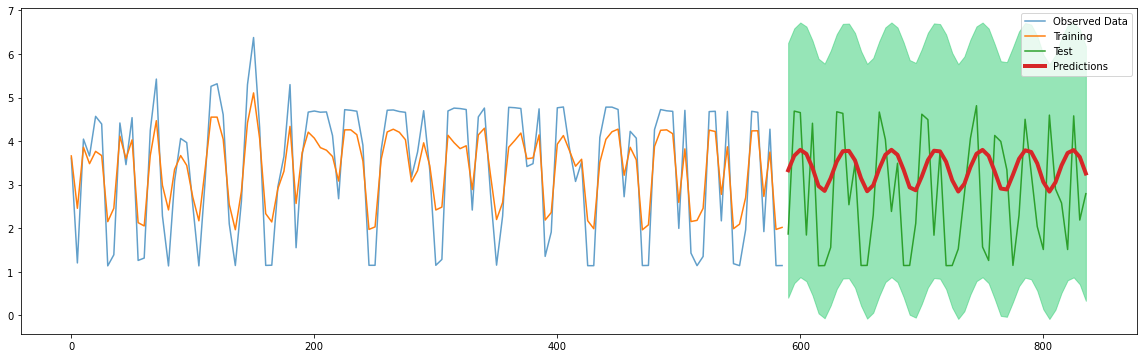

In [290]:
with torch.no_grad():

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(20, 6))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_train.numpy(), y_train.numpy(), alpha=0.7)
    ax.plot(X_train.numpy(), train_pred.mean.numpy())
    # Plot predictive means as blue line
    ax.plot(X_test.numpy(), y_test.numpy())
    ax.plot(X_test.numpy(), observed_pred.mean.numpy(), lw=4)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    ax.legend(['Observed Data', 'Training', 'Test', 'Predictions'])